In [7]:
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 10**3)
pd.set_option('display.max_rows', 10**3)

In [8]:
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import gc
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from sklearn.preprocessing import scale
import talib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import alphalens
import seaborn as sns
%matplotlib inline
sns.set_style('white')

In [9]:
from pathlib import Path
import pandas as pd
from utils import rank_stocks_and_quantile

top = 250  # parameters -> papermill
DATA_STORE = Path(f'data/{top}_dataset.h5')
dataset_key = 'data/YEAR_20220906_20230811'
label_col = 'TARGET_ret_fwd_01d' 
label = label_col + '_rank_quantiled'

with pd.HDFStore(DATA_STORE) as store:
    dataset = store[dataset_key]
    # print(dataset.index.levels[datetime_level].tz)

# Check and localize the datetime level of the MultiIndex to UTC if needed
datetime_level = 0  # Assuming the datetime is the first level
if dataset.index.levels[datetime_level].tz is None:
    localized_level = dataset.index.levels[datetime_level].tz_localize('UTC')
    dataset.index = dataset.index.set_levels(localized_level, level=datetime_level)

# Applying the rank_stocks_and_quantile function to the dataset
dataset_ranked = rank_stocks_and_quantile(dataset, TARGET_col=label_col)
print(dataset_ranked.info())

del dataset

# Assuming your DataFrame is named df
cols = dataset_ranked.columns.tolist()
# Populate the features list with column names starting with 'feature_'
features = [col for col in cols if col.startswith('FEATURE_')]
# Find the first column starting with 'target_' and set it as the label
label_cols = [col for col in cols if col.startswith('TARGET_')]
print(len(features))  # This will show all the columns starting with 'feature_'
print(label)  # This will show the first column starting with 'target_'

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 59607 entries, (Timestamp('2022-09-06 00:00:00+0000', tz='UTC'), 'AA') to (Timestamp('2023-08-11 00:00:00+0000', tz='UTC'), 'ZTS')
Columns: 600 entries, FEATURE_open to TARGET_ret_fwd_01d_rank_quantiled
dtypes: float32(360), float64(32), int32(198), int64(1), int8(9)
memory usage: 142.6+ MB
None
586
TARGET_ret_fwd_01d_rank_quantiled


In [10]:
import pandas as pd
import alphalens as al

def generate_alphalens_tearsheet(df: pd.DataFrame, \
    label_col: str, price_col: str) -> None:
    """
    Generate the Alphalens full tearsheet given the input dataframe, 
    label column and price data column.

    Parameters:
        df (pd.DataFrame): The input dataframe.
        label_col (str): The label column that contains the factor data.
        price_col (str): The column that contains price data.
    
    Returns:
        None: This function will print out the Alphalens full tearsheet.
    """
    # Extract the factor and trade_prices series
    factor = df[label_col]
    trade_prices = df[price_col]
    
    # Handle duplicate indices in trade_prices
    trade_prices = trade_prices[~trade_prices.index.duplicated(keep='first')]
    
    # Convert the trade_prices series into unstacked format (DataFrame with 
    # DatetimeIndex and tickers as columns)
    trade_prices_unstacked = trade_prices.unstack(level='ticker')
    
    # Ensure that the factor and trade_prices have the same timezone 
    # (if they don't, you might face issues)
    if factor.index.levels[0].tz != trade_prices_unstacked.index.tz:
        factor.index.set_levels(\
            factor.index.levels[0].tz_convert(trade_prices_unstacked.index.tz), \
            level=0, inplace=True)

    # Create the factor_data dataframe with forward returns
    alphalen_analysis = al.utils.get_clean_factor_and_forward_returns(
        factor=factor,
        prices=trade_prices_unstacked,
        periods=[1, 5, 10]
    )

    # Handle duplicate indices in factor_data
    alphalen_analysis = alphalen_analysis[~alphalen_analysis.index.duplicated(keep='first')]
    
    # Average out any remaining duplicate data points
    alphalen_analysis = alphalen_analysis.groupby(level=[0, 1]).mean()
    
    # # Generate the full tearsheet
    # al.tears.create_full_tear_sheet(factor_data)

    return alphalen_analysis

# # Assuming you have your df, label_col and price_col ready
# factor_data = generate_alphalens_tearsheet(factor_data, \
#     label_col='TARGET_ret_fwd_frac_order', price_col='FEATURE_open')


In [11]:
label_cols

['TARGET_ret_fwd_frac_order',
 'TARGET_ret_fwd_01d',
 'TARGET_ret_fwd_02d',
 'TARGET_ret_fwd_03d',
 'TARGET_ret_fwd_04d',
 'TARGET_ret_fwd_05d',
 'TARGET_ret_fwd_10d',
 'TARGET_ret_fwd_21d',
 'TARGET_ret_fwd_42d',
 'TARGET_ret_fwd_63d',
 'TARGET_ret_fwd_126d',
 'TARGET_ret_fwd_252d',
 'TARGET_ret_fwd_01d_rank',
 'TARGET_ret_fwd_01d_rank_quantiled']

In [12]:
# Assuming you have your original dataframe named df ready
alphalens_analysis = generate_alphalens_tearsheet(dataset_ranked, \
    label_col='TARGET_ret_fwd_126d', price_col='FEATURE_close')


alphalens_analysis

Dropped 4.3% entries from factor data: 4.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


1D        5D       10D    factor  \
date                      asset                                           
2022-09-06 00:00:00+00:00 AA    -0.005219  0.049677 -0.091421 -0.419225   
                          AAL    0.050681  0.034796  0.056732  0.028127   
                          AAPL   0.009256 -0.004466  0.015336 -0.006572   
                          ABBV   0.008142  0.006835  0.030381 -0.040454   
                          ABT    0.019369  0.030471 -0.003893 -0.090657   
...                                   ...       ...       ...       ...   
2023-07-28 00:00:00+00:00 WYNN   0.000000 -0.044045 -0.077354  0.058161   
                          X      0.033644 -0.022700 -0.079043 -0.115505   
                          XOM    0.029570  0.031298  0.073637 -0.072399   
                          YUM    0.005331 -0.018913 -0.020009  0.074456   
                          ZTS   -0.009531 -0.059347  0.004897  0.138697   

                                 factor_quantile  
date                      asset                   
2022-09-06 00:00:00+00:00 AA                 1.0  
                          AAL                4.0  
                          AAPL               3.0  
                          ABBV               3.0  
                          ABT                2.0  
...                                          ...  
2023-07-28 00:00:00+00:00 WYNN               3.0  
                          X                  1.0  
                          XOM                2.0  
                          YUM                4.0  
                          ZTS                4.0  

[56249 rows x 5 columns]

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1.0,-0.658354,0.025002,-0.207179,0.109244,11228,19.961244
2.0,-0.319278,0.125853,-0.067135,0.081519,11319,20.123024
3.0,-0.237576,0.209930,0.013086,0.083709,11201,19.913243
4.0,-0.145845,0.323794,0.102257,0.087079,11223,19.952355
5.0,-0.071058,2.013822,0.301830,0.209137,11278,20.050134


Returns Analysis


,1D,5D,10D
Ann. alpha,0.689,0.118,0.057
beta,-0.193,-0.187,-0.212
Mean Period Wise Return Top Quantile (bps),21.118,4.238,2.265
Mean Period Wise Return Bottom Quantile (bps),-16.970,-0.398,1.752
Mean Period Wise Spread (bps),38.088,4.653,0.573


<Figure size 640x480 with 0 Axes>

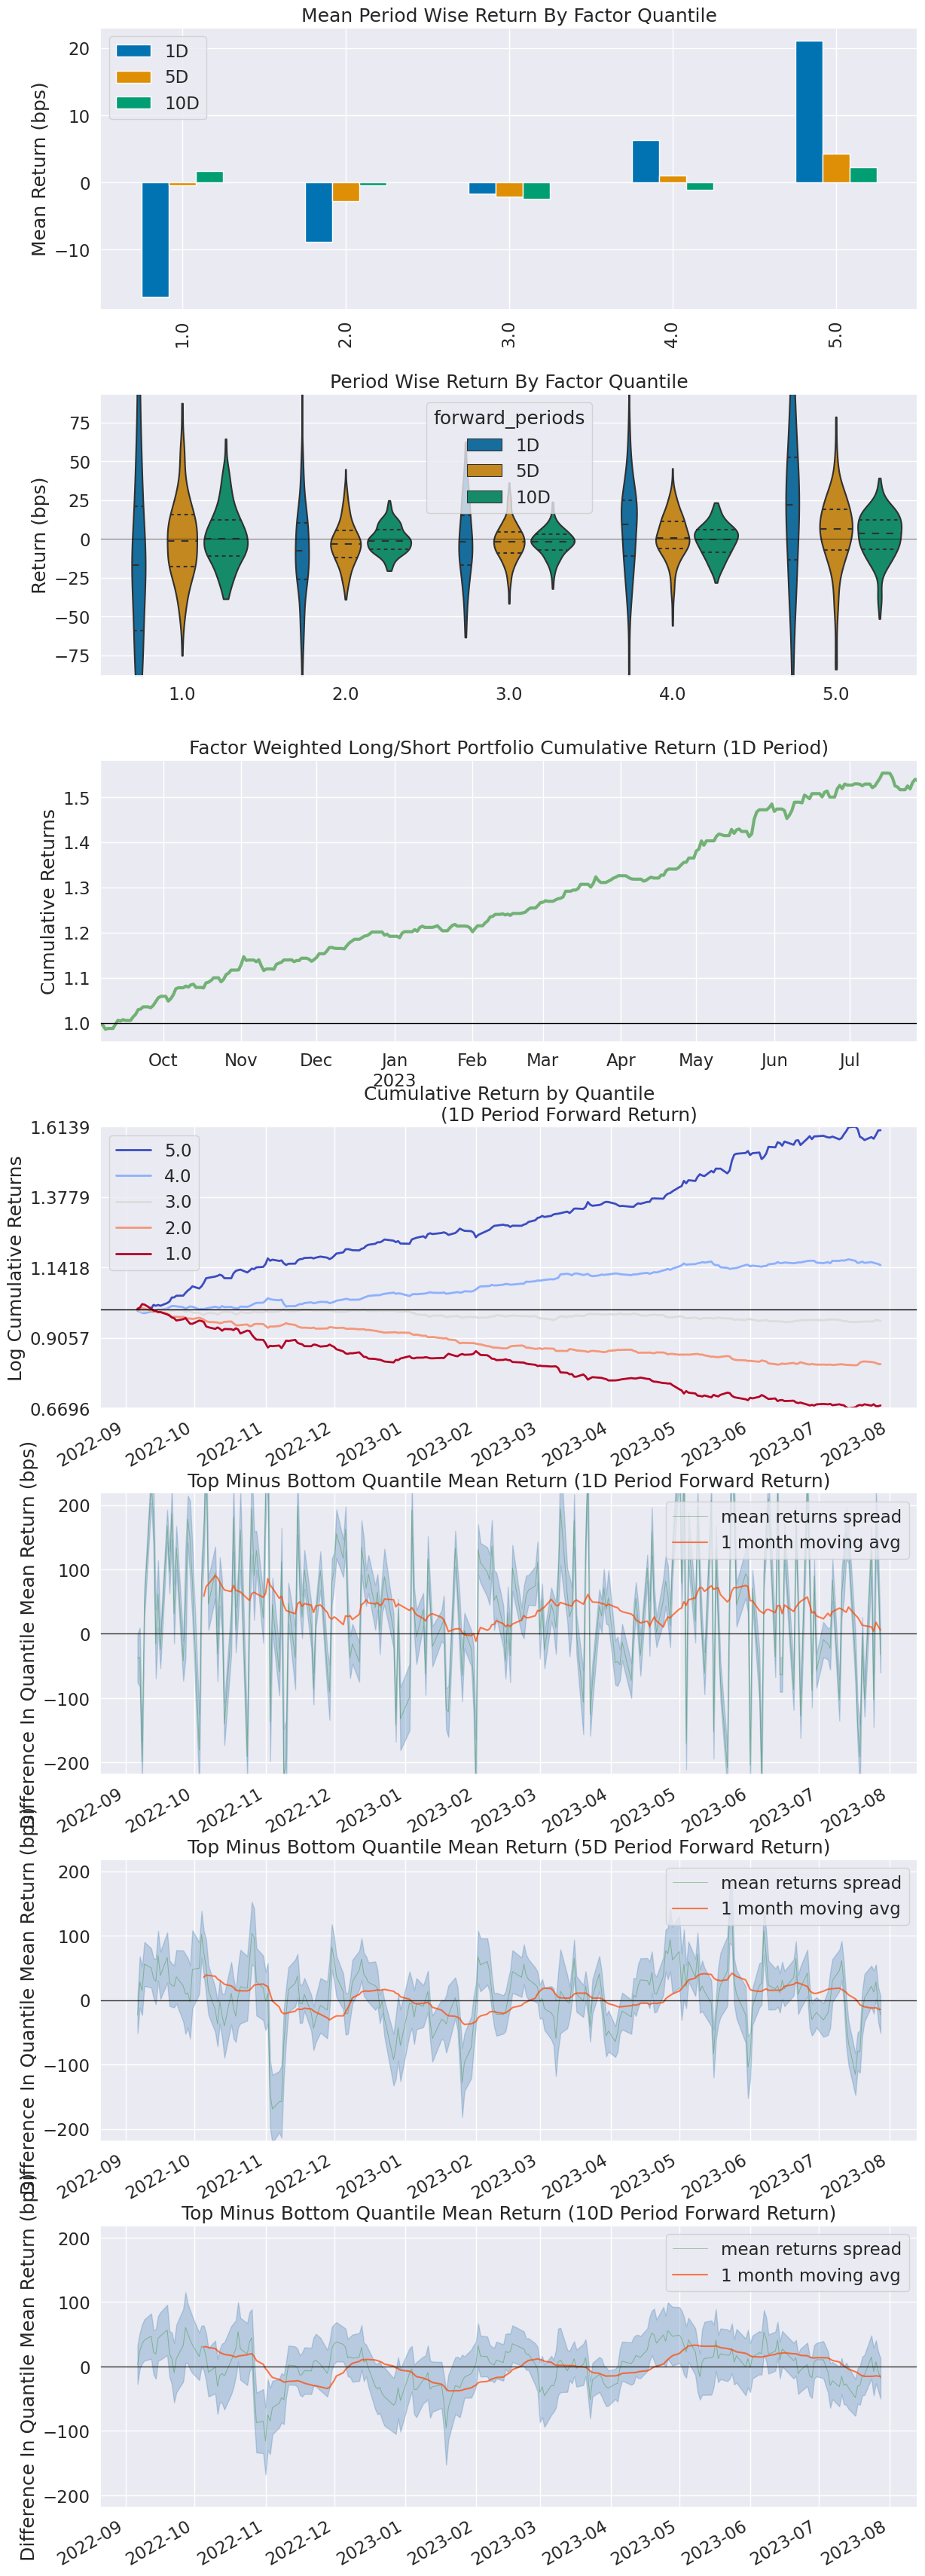

Information Analysis


,1D,5D,10D
IC Mean,0.078,0.026,0.009
IC Std.,0.217,0.206,0.189
Risk-Adjusted IC,0.361,0.125,0.045
t-stat(IC),NaN,NaN,NaN
p-value(IC),NaN,NaN,NaN
IC Skew,NaN,NaN,NaN
IC Kurtosis,NaN,NaN,NaN


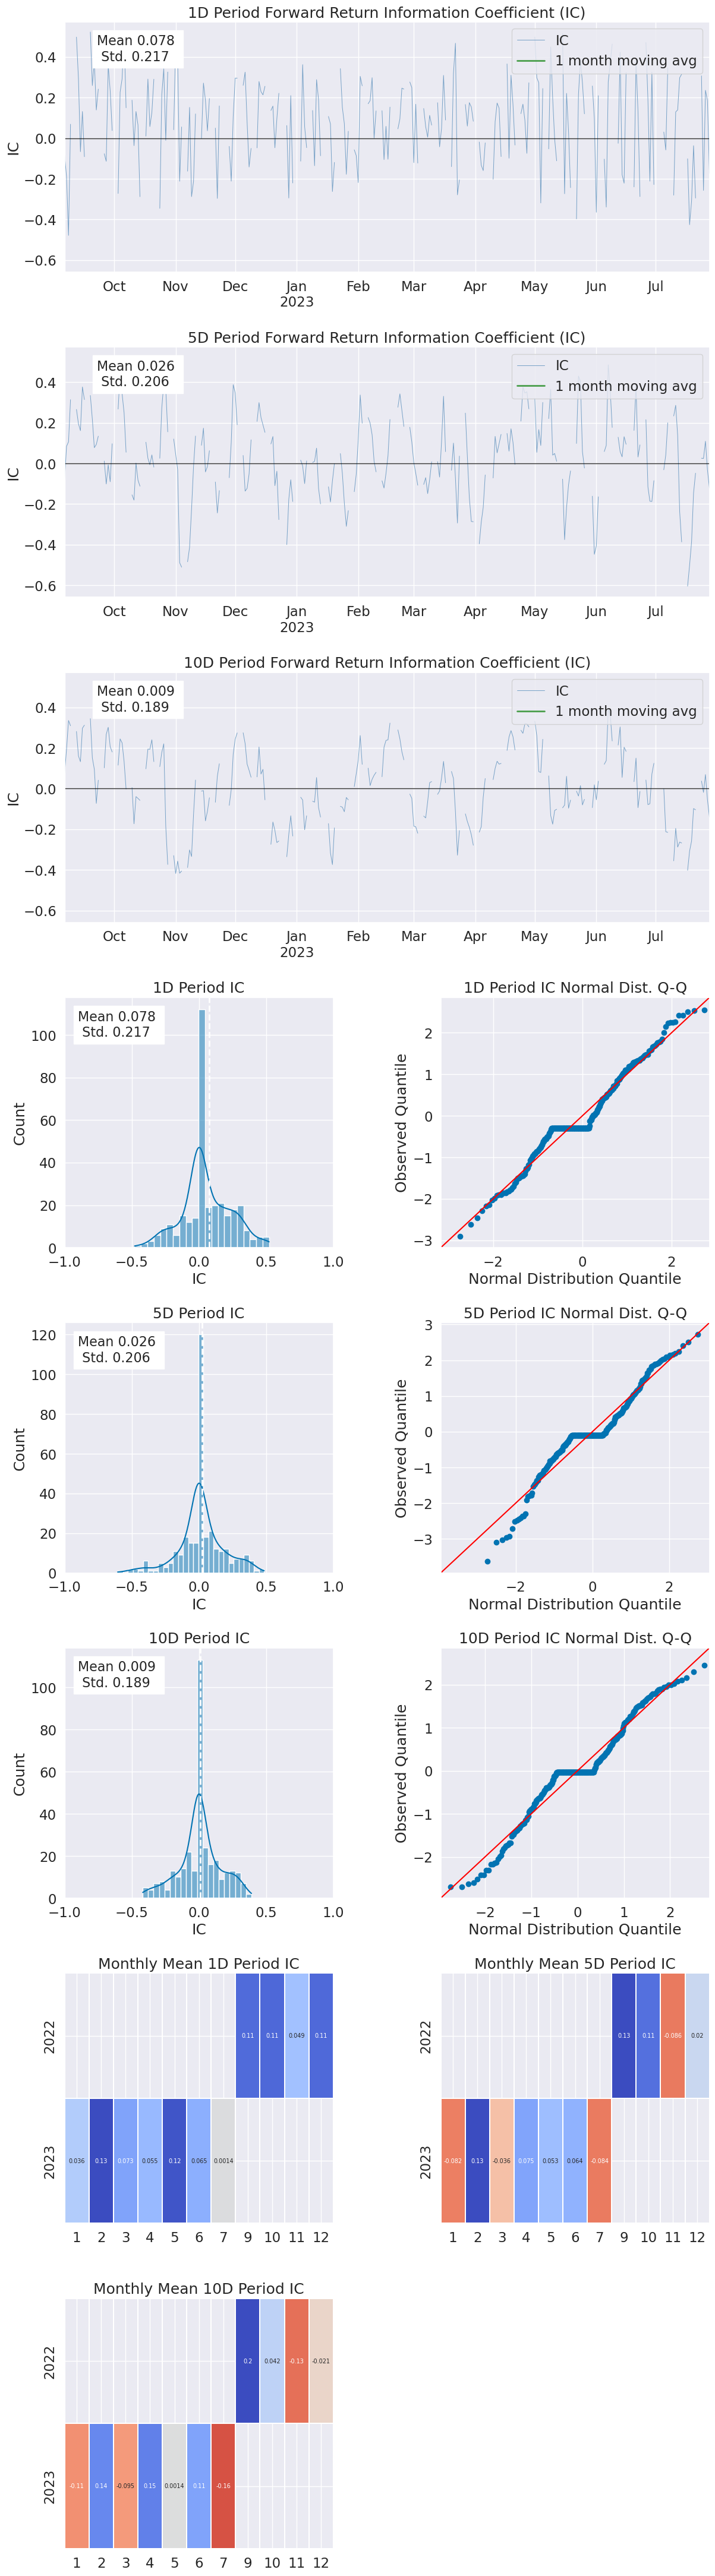

Turnover Analysis


,1D,5D,10D
Quantile 1.0 Mean Turnover,0.074,0.122,0.196
Quantile 2.0 Mean Turnover,0.176,0.288,0.423
Quantile 3.0 Mean Turnover,0.203,0.336,0.476
Quantile 4.0 Mean Turnover,0.172,0.286,0.421
Quantile 5.0 Mean Turnover,0.072,0.127,0.197


,1D,5D,10D
Mean Factor Rank Autocorrelation,0.987,0.965,0.912


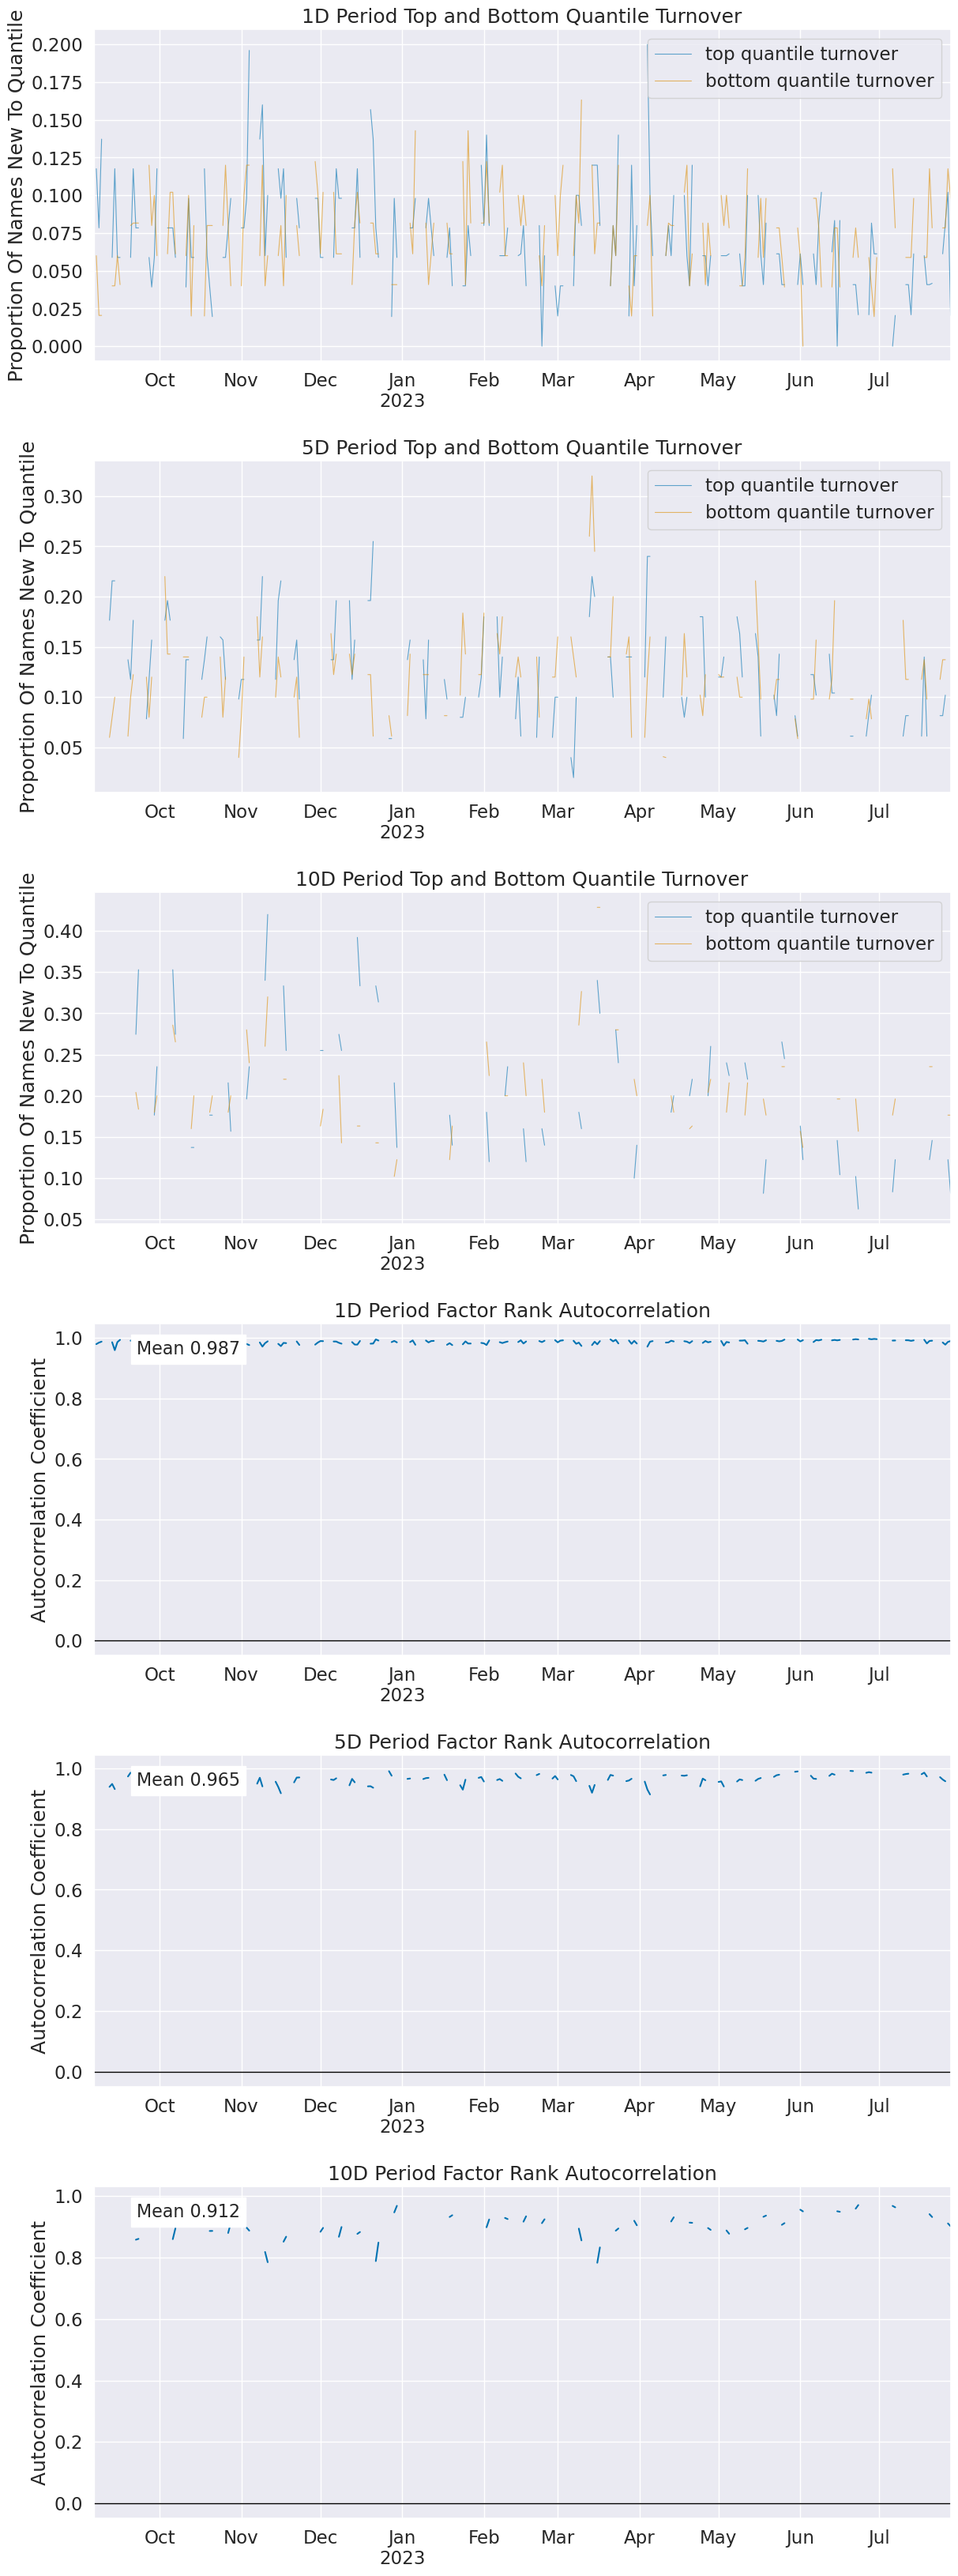

In [13]:
import alphalens as al
al.tears.create_full_tear_sheet(alphalens_analysis)